In [0]:
# Install package to be able to save keras weights
pip install h5py

In [0]:
# Mount google drive
from google.colab import drive
import os
drive.mount('my_drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at my_drive


In [0]:
# Load data and necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

path_data = "/content/my_drive/My Drive/Exjobb2/numpy_data.npy"
path_labels = "/content/my_drive/My Drive/Exjobb2/numpy_labels.npy"
data = np.load(path_data)
OHE_labels = np.load(path_labels)

In [0]:
# Load Some auxillary functions and data

# What value maps to what class
mapping = {
    0: "Null class",
    1: "Necrotic and non-enhancing tumor core",
    2: "Edema",
    4: "GD-enhancing tumor"
}

def OHE(Y, mapping):
    '''
    Takes in a picture as a matrix with labels and returns a one hot encoded tensor
    
    Parameters:
    Y is the picture
    Mapping is what value corresponds to what label
    
    Returns:
    A tensor with a channel for each label.
    '''
    shape = Y.shape
    labels = mapping.keys()
    one_hot_enc = np.zeros(list(shape) + [len(labels)])
    
    for i, label in enumerate(labels):
        temp = np.zeros(shape)
        ind = Y == label
        temp[ind] = 1
        one_hot_enc[:, :, i] = temp
    return one_hot_enc

def OHE_go_back(yhat, mapping):
  return None

# Some helper functions
def plot_modalities(x):
    # Make sure input data is of correct shape
    assert x.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(x[:,:,0])
    plt.axis('off')
    plt.title('T1')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(x[:,:,1])
    plt.axis('off')
    plt.title('T1ce')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(x[:,:,2])
    plt.axis('off')
    plt.title('T2')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(x[:,:,3])
    plt.axis('off')
    plt.title('FLAIR')
    plt.colorbar()

def plot_OHE(y):
    # Make sure input data is of correct shape
    assert y.shape == (240, 240, 4), 'Shape of input data is incorrect'
    
    plt.subplot('221')
    plt.imshow(y[:,:,0])
    plt.axis('off')
    plt.title('Null')
    plt.colorbar()

    plt.subplot('222')
    plt.imshow(y[:,:,1])
    plt.axis('off')
    plt.title('"Necrotic and non-enhancing tumor core"')
    plt.colorbar()

    plt.subplot('223')
    plt.imshow(y[:,:,2])
    plt.axis('off')
    plt.title('Edema')
    plt.colorbar()

    plt.subplot('224')
    plt.imshow(y[:,:,3])
    plt.axis('off')
    plt.title('GD-enhancing tumor')
    plt.colorbar()

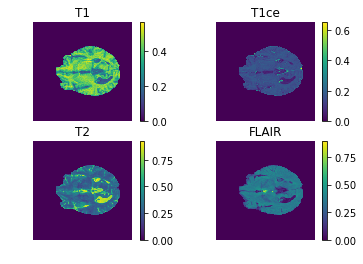

In [0]:
# This will show a slice of a patient
ind = 70

plot_modalities(data[ind, :, :, :])

In [0]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def unet(pretrained_weights = None, input_size = (256, 256, 1), num_classes=1):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
  
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
  
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
  
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size = (2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(drop5))
  merge6 = concatenate([drop4, up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv6))
  merge7 = concatenate([conv3, up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv7))
  merge8 = concatenate([conv2, up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(conv8))
  merge9 = concatenate([conv1, up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(num_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  
  # Not sure what the three lines below are doing
  reshape = Reshape((num_classes, input_size[0] * input_size[1]), input_shape = (num_classes, input_size[0], input_size[1]))(conv9)
  permute = Permute((2, 1))(reshape)
  activation = Softmax(axis=-1)(permute)
  
  model = Model(input = inputs, output = activation)
  model.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy')
  if (pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

Using TensorFlow backend.


In [0]:
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)
my_unet.summary()


In [0]:
# Initialise unet with untrained weights
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

# Train model
# n is how many samples to use at any time
n = 16
N = 16
epochs = 1
my_history = []
for e in range(epochs):
  print('\nEpoch: ' + str(e))
  for i in range(N//n):
#    if i % 5 == 0:
#        print('%', end='')
    # Pick n random slices
    #slices = np.random.randint(N, size=(n,))
    slices = 500
    train_data = data[1:slices, :, :, :]
    train_labels = OHE_labels[1:slices, :, :, :]

    # You have to reshape the output in this hacky way for keras to be able to use softmax in last layer
    train_labels = train_labels.reshape(slices, -1, 4)

    # Returns an object with accuracy and loss
    history = my_unet.fit(x=train_data, y=train_labels, batch_size=8, epochs=1, verbose=2, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
    my_history.append(history.history['loss'])
my_unet.save_weights("/content/my_drive/My Drive/Exjobb2/my_unet.h5")

In [0]:
# Initialise unet with untrained weights
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

print('data.shape: ' + str(data.shape))
print('OHE_labels.shape: ' + str(OHE_labels.shape))
labels = OHE_labels.reshape(775, -1, 4)
print('labels.shape: ' + str(labels.shape))

# If we want to save the model with val_loss in name
#filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'

#path_to_weights_many_weights = "/content/my_drive/My Drive/Exjobb2/weights{epoch:08d}.h5"
path_to_weights = "/content/my_drive/My Drive/Exjobb2/unet_weights.h5"
mc = ModelCheckpoint(path_to_weights, save_weights_only=True, period=1)

# Returns an object with accuracy and loss
history = my_unet.fit(x=data, y=labels, batch_size=None, epochs=5, verbose=1, callbacks=[mc], validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)

# Save weights of model
#my_unet.save_weights("/content/my_drive/My Drive/Exjobb2/my_unet.h5")
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = '/content/my_drive/My Drive/Exjobb2/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [0]:
# Overfit model on 1 data point
# Initialize network
my_unet = unet(input_size = (240, 240, 4), num_classes = 4)

# i = 70 has all labels present in the image
i = 70
x = data[i, :, :, :].reshape(1, 240, 240, 4)
y = OHE_labels[i, :, :, :]

# You have to reshape the output in this hacky way for keras to be able to use softmax in last layer
y = y.reshape(1, -1, 4)

# Returns an object with accuracy and loss
history = my_unet.fit(x=x, y=y, batch_size=None, epochs=500, verbose=2, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


Epoch 1/500
 - 11s - loss: 1.4213
Epoch 2/500
 - 7s - loss: 1.3440
Epoch 3/500
 - 7s - loss: 1.4511
Epoch 4/500
 - 7s - loss: 1.3945
Epoch 5/500
 - 7s - loss: 1.3969
Epoch 6/500
 - 7s - loss: 1.3940
Epoch 7/500
 - 7s - loss: 1.3936
Epoch 8/500
 - 7s - loss: 1.3910
Epoch 9/500
 - 7s - loss: 1.3930
Epoch 10/500
 - 7s - loss: 1.3942
Epoch 11/500
 - 7s - loss: 1.3943
Epoch 12/500
 - 7s - loss: 1.3923
Epoch 13/500
 - 7s - loss: 1.3881
Epoch 14/500
 - 7s - loss: 1.3802
Epoch 15/500
 - 7s - loss: 1.3790
Epoch 16/500
 - 7s - loss: 1.3794
Epoch 17/500
 - 7s - loss: 1.3813
Epoch 18/500
 - 7s - loss: 1.3833
Epoch 19/500
 - 7s - loss: 1.3846
Epoch 20/500
 - 7s - loss: 1.3848
Epoch 21/500
 - 7s - loss: 1.3853
Epoch 22/500
 - 7s - loss: 1.3874
Epoch 23/500
 - 7s - loss: 1.3892
Epoch 24/500
 - 7s - loss: 1.3892
Epoch 25/500
 - 7s - loss: 1.3889
Epoch 26/500
 - 7s - loss: 1.3878
Epoch 27/500
 - 7s - loss: 1.3875
Epoch 28/500
 - 7s - loss: 1.3867
Epoch 29/500
 - 7s - loss: 1.3861
Epoch 30/500
 - 7s - l

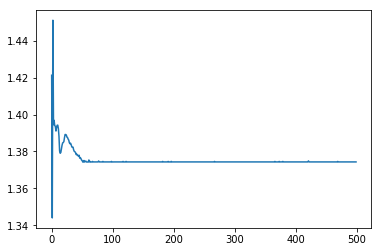

In [0]:
#plt.plot(np.array(my_history).flatten())
plt.plot(history.history['loss'])

[[0.   0.25 0.25 ... 0.25 0.25 0.  ]
 [0.25 0.25 0.25 ... 0.25 0.25 0.  ]
 [0.25 0.25 0.25 ... 0.25 0.25 0.  ]
 ...
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]


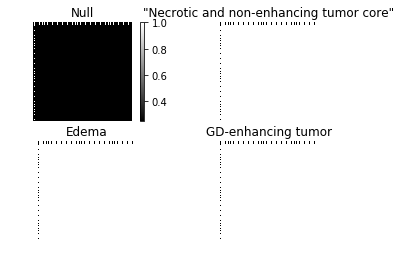

In [0]:
# Make a prediction on a sample with index m
m = 401
x = data[m, :, :, :].reshape(1, 240, 240, 4)
y = OHE_labels[m, :, :, :]
y = y.reshape(1, -1, 4)

yhat = my_unet.predict(x = x)
yhat = yhat.reshape([240, 240, 4])
plot_OHE(yhat)
print(yhat[:,:,1])

In [0]:
# Test on 100 samples which the network was not trained on
test_data = data[samples_used:(samples_used+100), :, :, :]
test_labels = OHE_labels[samples_used:(samples_used+100), :, :, :]
test_labels = test_labels.reshape(100, -1, 4)
print(my_unet.evaluate(x = test_data, y=test_labels))


100/100 [==============================] - 7s 69ms/step
[1.3862923383712769, 0.9903882050514221]
